In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(0)

Consider control of Brownian motion
$$
dX_{t} = dW_{t} + u_{t}dt
$$

Ergodic control
$$
\min_{u}\liminf_{T\to\infty}\frac{1}{T}E\big[\int_{0}^{T}c(X_t,u_t)dt\big]
$$

where
$$
c(X_{t},u_{t}) = X_{t}^{2} + u_{t}^{2}
$$

Naive approach, considering the truncated problem
$$
u^{*} = \arg\min E\big[\int_{t_{n}}^{t_{n+1}}c(X_{t},u_{t})dt\big]
$$


Model: "control_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 16        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


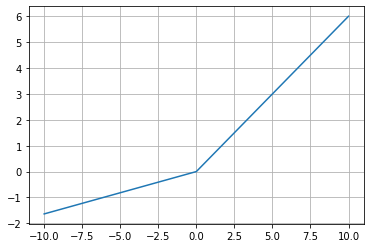

In [2]:
# Control Neural Network: u(x)

inputs = keras.Input(shape=(1))
l1 = layers.Dense(8, activation = 'relu')
l2= layers.Dense(1, activation = 'linear')
outputs = l1(inputs)
outputs = l2(outputs)
# outputs = -inputs
control_NN = keras.Model(inputs=inputs, outputs=outputs, name = 'control_NN')
control_NN.summary()
control_NN.compile(loss = 'mse')
xgrid = np.linspace(-10,10,201)
y = control_NN.predict(xgrid)
plt.plot(xgrid,y)
plt.grid()

In [3]:
# Global Parameter
steps = 100
dt = 0.1
sqrtdt = np.sqrt(dt)
T = steps * dt
M = 1000

## Discrete approximation
Euler Forward:
$$
X_{t+1}^{u} = X_{t}^{u} + dW_{t} + u(X_{t}^{u})dt \
$$

Left point integral:
$$
\text{Control Main} = \frac{1}{T-t}\int_{t}^{T}c(X_{s}^{u},u_{s})ds
$$

$$
\text{Control Terminal} = X^{u}_{T}
$$

$$
\text{Control Main} = c(X_{s}^{u},u_{s}),\quad s = t,\cdots,T
$$

In [4]:
input_x = keras.Input(shape=(1))
inputs = [input_x]

X_now = input_x
u_now = control_NN(X_now)
loss = tf.math.square(X_now) + tf.math.square(u_now)
loss_output = [loss]
counts = 0
for i in range(steps):
    input_dW = keras.Input(shape=(1))
    inputs = inputs + [input_dW]
    u_now = control_NN(X_now)
    X_next  = X_now + input_dW + u_now * dt
    loss_tmp = tf.math.square(X_now) + tf.math.square(u_now)
    loss_output = loss_output + [loss_tmp]
    if i > steps/2:
        loss = loss + loss_tmp
        counts += 1
    X_now = X_next
outputs = loss / counts
# outputs = loss_tmp
control_main = keras.Model(inputs=inputs, outputs = outputs, name = 'control_main')
control_terminal = keras.Model(inputs=inputs, outputs = X_now, name = 'control_terminal')
control_loss = keras.Model(inputs=inputs, outputs = loss_output, name = 'control_loss')
# control_loss.summary()

control_main.compile(loss = 'mean_absolute_error')
control_terminal.compile(loss = 'mean_absolute_error')
control_loss.compile(loss = 'mean_absolute_error')

In [5]:
def trainning_data(seed,X0,samplesM):
    np.random.seed(seed)
    x = [X0]
    for i in range(steps):
        x = x + [np.random.normal(0,sqrtdt,size = (samplesM,1))]
    y = np.zeros(shape = (samplesM,1))
    return x, y

In [6]:
# X0 = np.random.normal(0,np.sqrt(1/2),size = (M,1))
X0 = np.ones(shape = (M,1))
# X0 = np.zeros(shape = (M,1))
x_train, y_train = trainning_data(0,X0,M)
x_valid, y_valid = trainning_data(1,X0,M)
x_test, y_test = trainning_data(2,X0,M)

mean cost:  1.070332368398875
terminal mean:  0.05852963082889483
terminal variance:  0.5380155384384356


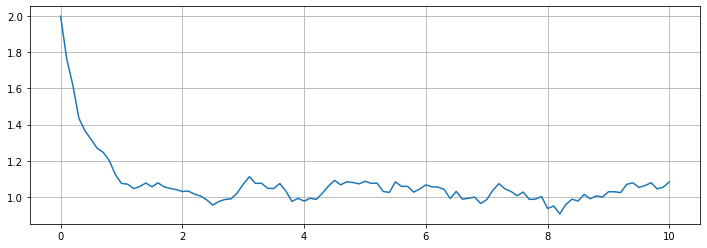

In [7]:
# Optimal control
X = x_train[0][:,0]
rho = np.zeros(steps+1)
rho[0] = np.mean(2*X**2)
for it in range(steps):
    dW = x_train[it+1][:,0]
    X  = X + dW + -X*dt
    rho[it+1] = np.mean(2*X**2)
    
plt.rcParams['figure.figsize'] = (12.0, 4.0)
dates = np.linspace(0,steps*dt,steps+1)
plt.plot(dates,rho)
plt.grid()
print('mean cost: ', rho.mean())
print('terminal mean: ', X.mean())
print('terminal variance: ', X.var())

In [8]:
control_main.evaluate(x_train,y_train)
control_main.fit(x_train,y_train,epochs = 20,validation_data = (x_valid,y_valid), verbose = 1)

1000/1000 [==============================] - 2s 2ms/sample - loss: 43419.4568
Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 9s 9ms/sample - loss: 14732.1728 - val_loss: 5739.0404
Epoch 2/20
1000/1000 [==============================] - 1s 1ms/sample - loss: 3058.1746 - val_loss: 1735.5135
Epoch 3/20
1000/1000 [==============================] - 1s 1ms/sample - loss: 920.3875 - val_loss: 532.1523
Epoch 4/20
1000/1000 [==============================] - 1s 1ms/sample - loss: 299.3119 - val_loss: 186.1273
Epoch 5/20
1000/1000 [==============================] - 1s 1ms/sample - loss: 101.9859 - val_loss: 63.7598
Epoch 6/20
1000/1000 [==============================] - 1s 1ms/sample - loss: 35.5960 - val_loss: 23.3586
Epoch 7/20
1000/1000 [==============================] - 1s 1ms/sample - loss: 13.6411 - val_loss: 9.6362
Epoch 8/20
1000/1000 [==============================] - 1s 1ms/sample - loss: 6.2790 - val_loss: 4.7754
Epoch 9/20
1000

mean cost:  1.129482623964253
terminal mean after 1 iteration:  -0.011101332
terminal variance after 1 iteration:  0.5724773


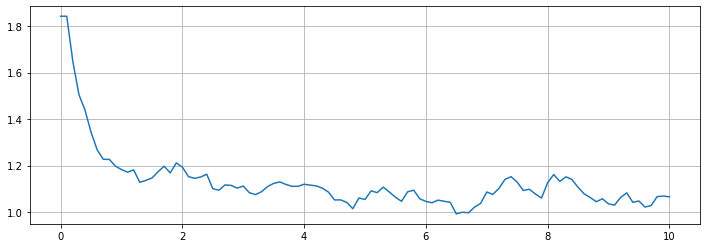

In [9]:
all_loss = control_loss.predict(x_test)
plt_loss = np.zeros(steps+1)
for i,x in enumerate(all_loss):
    plt_loss[i] = x.mean()
plt.plot(dates,plt_loss)
plt.grid()
X_end = control_terminal.predict(x_test)

print('mean cost: ', plt_loss.mean())
print('terminal mean after 1 iteration: ', X_end.mean())
print('terminal variance after 1 iteration: ', X_end.var())

mean cost:  1.0876763840713124
terminal mean after 1 iteration:  0.05198631
terminal variance after 1 iteration:  0.5969174
Train on 1000 samples, validate on 1000 samples
1000/1000 [==============================] - 8s 8ms/sample - loss: 1.1066 - val_loss: 1.1014
mean cost after 2 iteration 1.070132846289342
terminal mean after 2 iteration:  -0.0639579
terminal variance after 2 iteration:  0.53945816
Train on 1000 samples, validate on 1000 samples
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.0826 - val_loss: 1.0882
mean cost after 3 iteration 1.0550430499681152
terminal mean after 3 iteration:  0.005817137
terminal variance after 3 iteration:  0.5777031
Train on 1000 samples, validate on 1000 samples
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.1075 - val_loss: 1.0728
mean cost after 4 iteration 1.0693788428117734
terminal mean after 4 iteration:  -0.016850056
terminal variance after 4 iteration:  0.5533651
Train on 1000 samples, validat

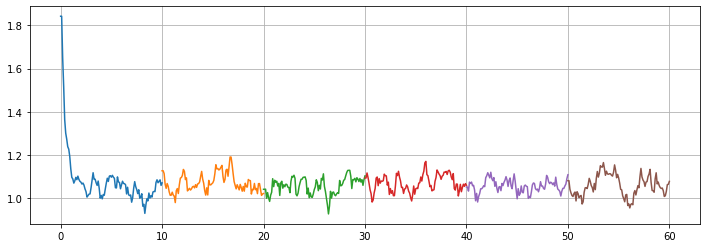

In [10]:
all_loss = control_loss.predict(x_train)
plt_loss = np.zeros(steps+1)
for i,x in enumerate(all_loss):
    plt_loss[i] = x.mean()
plt.plot(dates,plt_loss)
plt.grid()
X_end = control_terminal.predict(x_train)
print('mean cost: ', plt_loss.mean())
print('terminal mean after 1 iteration: ', X_end.mean())
print('terminal variance after 1 iteration: ', X_end.var())

for i in range(5):
#     newX0 = np.random.normal(X_end.mean(),X_end.std(),size = (M,1))
    newX0 = X_end
    x_t, y_t = trainning_data(i+5,newX0,M)
    x_v, y_v = trainning_data(i+500,newX0,M)
    control_main.fit(x_t,y_t,epochs = 1,validation_data = (x_v,y_v), verbose = 1)
    
    all_loss = control_loss.predict(x_t)
    plt_loss = np.zeros(steps+1)
    for j,x in enumerate(all_loss):
        plt_loss[j] = x.mean()
    plt.plot(dates+T*(i+1),plt_loss)
    X_end = control_terminal.predict(x_t)
    print(f'mean cost after {i+2} iteration', plt_loss.mean())
    print(f'terminal mean after {i+2} iteration: ',  X_end.mean())
    print(f'terminal variance after {i+2} iteration: ',  X_end.var())

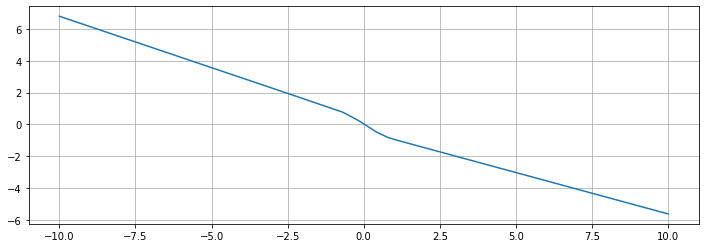

In [11]:
control_NN.compile(loss = 'mse')
xgrid = np.linspace(-10,10,201)
y = control_NN.predict(xgrid)
plt.plot(xgrid,y)
plt.grid()

Iteratively find the optimal control $u$ of finite horizon problem and drive the controlled process with $u$ until the distribution stable. 

Note: Here the optimal control $u$ is computed in a naive way by finding the best $u$ for an initial distribution. Alternative approch can be using the value function $V(t,x)$ which gives the best value not only for a fixed initial distribution but for any distribution. 

This method simply truncated the ergodic problem to the finite horizon problem. This is reasonable when the optimal control of finite horizon problem is closed to the optimal control of ergodic problem, because then the controlled process coverges to the stationay distribution exponentially. 

This method can be extended to multidimensional diffusion control if we can prove that 
1. the optimal control of finite horizonal problem is closed to ergodic one
2. the optimal controlled process converges in distribution exponentially



